In [1]:
import glob
import csv
import numpy as np
from Bio import SeqIO
from Bio.Seq import Seq
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import linregress
from scipy import stats
import statistics
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score, average_precision_score, roc_curve, precision_recall_curve, confusion_matrix

In [6]:
with open('nbt_pred_combined_f24_filter.csv','w') as csvfile:
    mywriter = csv.writer(csvfile)
    mywriter.writerow(['guide','gene','refseq','binary_relative_ratio','pos','ratio','relative_ratio',
                      'guideSeq23','matchPos_end','nbt_guideScores','nbt_Rank','nbt_standardizedGuideScore','nbt_quartiles','refseqid'])
    for g in guide_com_info:
        mywriter.writerow(g)

## essential gene prediction

In [2]:
pred_path = '../prediction_results/Sanjana_pred_essential_genes.csv'
df_pred = pd.read_csv(pred_path)
dataframe_pred = df_pred[['guide','nbt_guideScores','nbt_Rank','nbt_standardizedGuideScore','nbt_quartiles']]

df_final = pd.read_csv('../data/integrated_guide_feature_filtered_f24_mismatch3_all_features.csv')
df_final_info = df_final[['guide','gene','refseq','raw ratio','relative_ratio','binary_relative_ratio_075f']]

df_all = dataframe_pred.merge(df_final_info, left_on='guide', right_on='guide')
genes = set(df_all['gene'].values)
len(genes)

54

In [3]:
def get_classification_metrics(model_name, y_pred,y_true,showplot = False):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    fig.suptitle('AUC and PRC')
    score = roc_auc_score(y_true, y_pred)
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    print('AUROC '+str(score))
    average_precision = average_precision_score(y_true, y_pred)
    precision, recall, thres_prc  = precision_recall_curve(y_true, y_pred)
    print('AUPRC '+str(average_precision))

    ax1.plot(fpr, tpr, label='AUROC=%f' % (score) )
    ax2.plot(precision, recall, label='AUPRC=%f' % (average_precision))
    if showplot:
        ax1.legend(bbox_to_anchor=(0, 1.5), loc = 'upper left', fontsize=6)
        ax1.set_title('Test Set AUROC')
        ax1.set_xlabel('false positive rate')
        ax1.set_ylabel('true positive rate')
        ax1.set_aspect('equal')

        ax2.legend(bbox_to_anchor=(0, 1.5), loc = 'upper left', fontsize=6)
        ax2.set_title('Test Set AUPRC')
        ax2.set_xlabel('precision')
        ax2.set_ylabel('recall')
        ax2.set_aspect('equal')
        plt.tight_layout()
        #plt.savefig(fname='cas13design-nbt-results/classification_auc_new.svg',bbox_inches='tight')
        #plt.clf()

AUROC 0.7372027161241121
AUPRC 0.3618042289696437


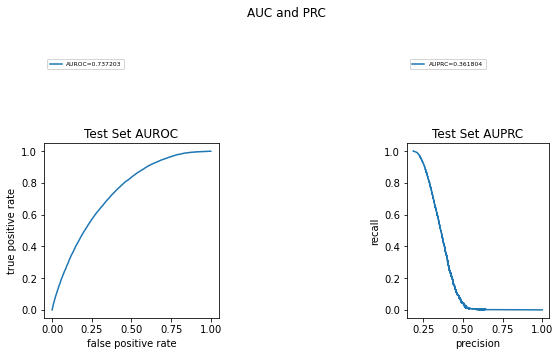

In [4]:
#overall prediction
y_true = df_all['binary_relative_ratio_075f'].values 
y_pred = df_all['nbt_standardizedGuideScore'].values
get_classification_metrics('nbt_random_forest', y_pred,y_true,showplot = True)

In [5]:
# iterate over genes and average results
auroc_all = []
auprc_all = []
spearmanr_all = []
for gene in genes:
    gene_df = df_all[df_all['gene'] == gene]
    pred = gene_df['nbt_standardizedGuideScore'].values
    rank_t =  1- gene_df['relative_ratio'].values
    goodg_true = gene_df['binary_relative_ratio_075f'].values
    auroc = roc_auc_score(goodg_true, pred)
    auprc = average_precision_score(goodg_true, pred)
    sr, srp = stats.spearmanr(pred,rank_t)
    auroc_all.append(auroc)
    auprc_all.append(auprc)
    spearmanr_all.append(sr)
    
auroc_mean = statistics.mean(auroc_all)
auroc_sd = statistics.stdev(auroc_all)
print('auroc_mean: '+str(auroc_mean))
print('auroc_sd: '+str(auroc_sd))
auprc_mean = statistics.mean(auprc_all)
auprc_sd = statistics.stdev(auprc_all)
print('auprc_mean: '+str(auprc_mean))
print('auprc_sd: '+str(auprc_sd))
sr_mean = statistics.mean(spearmanr_all)
sr_sd = statistics.stdev(spearmanr_all)
print('spearmanr_mean: '+str(sr_mean))
print('spearmanr_sd: '+str(sr_sd))

auroc_mean: 0.7302715907125062
auroc_sd: 0.04237685725081342
auprc_mean: 0.37562190169610327
auprc_sd: 0.0703688974445451
spearmanr_mean: 0.3822650636224031
spearmanr_sd: 0.10092893199384043


## CD genes

In [6]:
#new data and pred, t1 specific
dataf = '../data/cdscreen_filtered_t1_new_features_ratios.csv'
data_df = pd.read_csv(dataf)
guide_23nt = [guide[:23] for guide in data_df['guide'].values]
data_df['guide_23nt'] = guide_23nt
#data_df['nbt_position'] = data_df['absolute_position_start']+30 # convert to end pos, 1 index, only good for transcript1
#different transcript
cd58_t1 = data_df[data_df['refseq']=='NM_001779.3']
cd81_t1 = data_df[data_df['refseq']=='NM_004356.4']
# pred
cd58_t1_pred = pd.read_csv('../prediction_results/Sanjana_pred_cd58_ENST00000369489_Cas13guides.csv')
cd58_t1_all = cd58_t1.merge(cd58_t1_pred, left_on='guide_23nt', right_on='Guide sequence')
cd58_t1_all['t1_bin1_to_sum_bin14_rank']= cd58_t1_all['bin1_to_sum_bin14_rank_withr3'].rank(pct=True)
rank_t =  cd58_t1_all['t1_bin1_to_sum_bin14_rank'].values
labels = cd58_t1_all['t1_binary_relative_ratio_withrep3'].values
pred_rank = (cd58_t1_all['Guide score'].rank(pct=True,ascending=False)).values

_, _, r_value, _, _ = linregress(rank_t, pred_rank)
r2_s = r2_score(rank_t, pred_rank)
#mean_error = float(np.mean(np.abs(np.array(outputs) - np.array(labels))))
msev = float(np.mean((pred_rank -rank_t)**2))
sr, srp = stats.spearmanr(pred_rank,rank_t)
auroc = roc_auc_score(labels, 1-pred_rank)
auprc = average_precision_score(labels, 1-pred_rank)
auroc_all.append(auroc)
auprc_all.append(auprc)
spearmanr_all.append(sr)
print('cd58_t1: NM_001779.3')
print('MSE '+str(msev))
print('R squared '+ str(r_value ** 2))
print('sklearn r2 '+str(r2_s))
print('spearmanr '+str(sr))
#get_classification_metrics('cnnhp1', 0, 1-pred_rank,labels,save = False)
print('auroc: '+str(auroc))
print('auroc: '+str(auprc))

cd81_t1_pred = pd.read_csv('../prediction_results/Sanjana_pred_cd81_ENST00000263645_Cas13guides.csv')
cd81_t1_all = cd81_t1.merge(cd81_t1_pred, left_on='guide_23nt', right_on='Guide sequence')
cd81_t1_all['t1_bin1_to_sum_bin14_rank']=cd81_t1_all['bin1_to_sum_bin14_rank_withr3'].rank(pct=True)
rank_t =  cd81_t1_all['t1_bin1_to_sum_bin14_rank'].values
labels = cd81_t1_all['t1_binary_relative_ratio_withrep3'].values
pred_rank = (cd81_t1_all['Guide score'].rank(pct=True,ascending=False)).values
_, _, r_value, _, _ = linregress(rank_t, pred_rank)
r2_s = r2_score(rank_t, pred_rank)
#mean_error = float(np.mean(np.abs(np.array(outputs) - np.array(labels))))
msev = float(np.mean((pred_rank -rank_t)**2))
sr, srp = stats.spearmanr(pred_rank,rank_t)
auroc = roc_auc_score(labels, 1-pred_rank)
auprc = average_precision_score(labels, 1-pred_rank)
auroc_all.append(auroc)
auprc_all.append(auprc)
spearmanr_all.append(sr)
print('cd81_t1: NM_004356.4')
print('MSE '+str(msev))
print('R squared '+ str(r_value ** 2))
print('sklearn r2 '+str(r2_s))
print('spearmanr '+str(sr))
#get_classification_metrics('cnnhp1', 0, 1-pred_rank,labels,save = False)
print('auroc: '+str(auroc))
print('auroc: '+str(auprc))

cd58_t1: NM_001779.3
MSE 0.06098337813212965
R squared 0.40208183739452175
sklearn r2 0.268198479825856
spearmanr 0.6340992330814803
auroc: 0.8037137769936947
auroc: 0.46778290330217365
cd81_t1: NM_004356.4
MSE 0.06574780757424367
R squared 0.3666458648046137
sklearn r2 0.21102581606954463
spearmanr 0.6055128940035989
auroc: 0.7823543644146659
auroc: 0.49960139097639583


## prediction for all genes

In [7]:
pred_all_genes = {'AUROC':auroc_all,'AUPRC':auprc_all,'Spearman R':spearmanr_all}
# Create DataFrame
df_all = pd.DataFrame(pred_all_genes)
df_all.to_csv('../prediction_results/Sanjana_pred_accuracy_allgenes.csv',index=False)

In [8]:
auroc_mean = statistics.mean(auroc_all)
auroc_sd = statistics.stdev(auroc_all)
print('auroc_mean: '+str(auroc_mean))
print('auroc_sd: '+str(auroc_sd))
auprc_mean = statistics.mean(auprc_all)
auprc_sd = statistics.stdev(auprc_all)
print('auprc_mean: '+str(auprc_mean))
print('auprc_sd: '+str(auprc_sd))
sr_mean = statistics.mean(spearmanr_all)
sr_sd = statistics.stdev(spearmanr_all)
print('spearmanr_mean: '+str(sr_mean))
print('spearmanr_sd: '+str(sr_sd))

auroc_mean: 0.7325131078550661
auroc_sd: 0.0432755020572332
auprc_mean: 0.379481553319074
auprc_sd: 0.07204478008263333
spearmanr_mean: 0.390748670762408
spearmanr_sd: 0.10863801839488761


## our models' prediction

CD46
spearmanr 0.6719232488229567
AUROC 0.8542219387755102
AUPRC 0.5884646376049298
CD55
spearmanr 0.6920219198685451
AUROC 0.876039439296745
AUPRC 0.5934203594519767
CD71
spearmanr 0.6613802630431892
AUROC 0.8876673963430337
AUPRC 0.6677470516128495


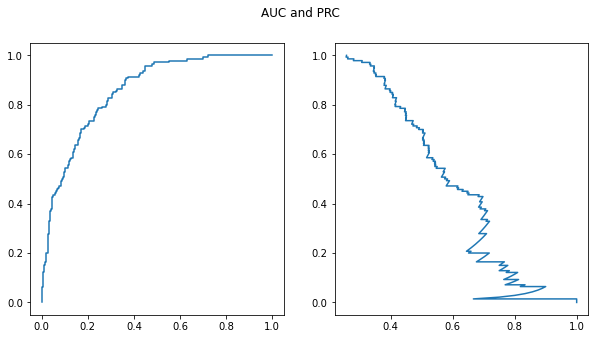

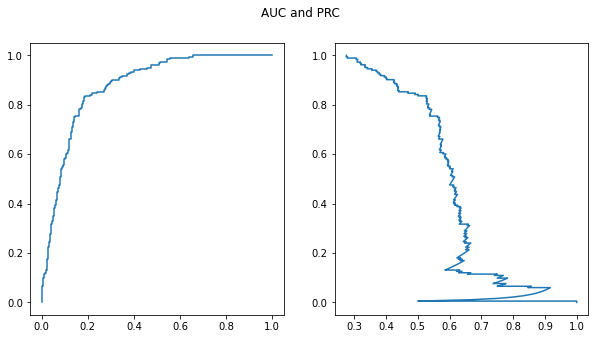

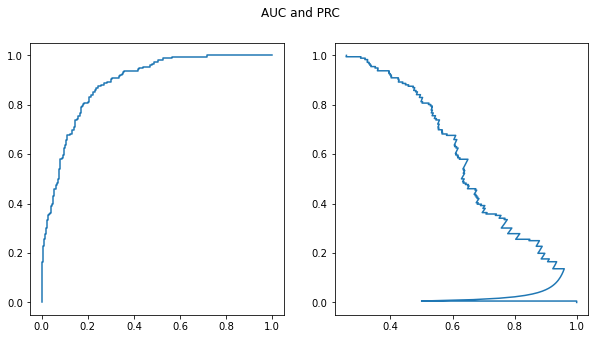

In [18]:
#23nt version
inputf = '../data/Sanjana_CD_data_23nt_filtered_all_features.csv'
predf1 = 'results/all_guide_f24_mis3_kfold_1genef_9fold_top20gene_new_nbt_23nt/guide_nolin_eightf_classification/test_prediction_gl-23_ensemble.csv'
df_in = pd.read_csv(inputf)
df_pred1 = pd.read_csv(predf1)
df_all1= df_in.merge(df_pred1, left_on='guide', right_on='spacer sequence')
df_all1["pred_rank_by_gene_pct"] = df_all1.groupby("Screen")["predicted_value_sigmoid"].rank(pct=True)

gene_list =['CD46','CD55','CD71']
for gene in gene_list:
    gene_df = df_all1[df_all1["Screen"]==gene]
    rank_t =  1- gene_df['relative_ratio'].values
    pred_rank = gene_df['pred_rank_by_gene_pct'].values
    goodg_true = gene_df['binary_relative_ratio'].values
    sr, srp = stats.spearmanr(pred_rank,rank_t)
    print(gene)
    print('spearmanr '+str(sr))
    get_classification_metrics('cnnhp1_noiso', gene_df["predicted_value_sigmoid"].values,goodg_true,save = False)

<Figure size 432x288 with 0 Axes>

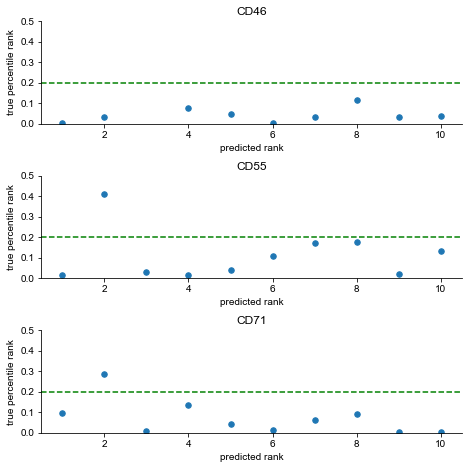

In [23]:
#top10 guides for each gene
plt.clf()
plt.rcParams['svg.fonttype'] = 'none'
# change font
plt.rcParams['font.sans-serif'] = "Arial"
plt.rcParams['font.family'] = "sans-serif"

df_all1["pred_rank_by_gene"] = df_all1.groupby("Screen")["predicted_value_sigmoid"].rank(ascending=False)
cd46 = df_all1[df_all1["Screen"]=='CD46']
cd46_top10 = cd46[cd46["pred_rank_by_gene"]<=10]

cd55 = df_all1[df_all1["Screen"]=='CD55']
cd55_top10 = cd55[cd55["pred_rank_by_gene"]<=10]

cd71 = df_all1[df_all1["Screen"]=='CD71']
cd71_top10 = cd71[cd71["pred_rank_by_gene"]<=10]

#plt.style.use('seaborn-whitegrid')
fig, axs =  plt.subplots(3,figsize=(6.4,6.4),constrained_layout=True)
sns.despine(left=False, bottom=False)

axs[0].scatter(cd46_top10['pred_rank_by_gene'].values,cd46_top10['relative_ratio'].values,
               s=30, label='CD46')
axs[0].set_title('CD46')
axs[0].set_xlabel('predicted rank')
axs[0].set_ylabel('true percentile rank')
axs[0].axhline(y=0.2,color='g', linestyle='--')
axs[0].set_ylim((0, 0.5))
axs[0].set_xlim((0.5, 10.5))

axs[1].scatter(cd55_top10['pred_rank_by_gene'].values,cd55_top10['relative_ratio'].values,
               s=30,label='CD55')
axs[1].set_title('CD55')
axs[1].set_xlabel('predicted rank')
axs[1].set_ylabel('true percentile rank')
axs[1].axhline(y=0.2,color='g', linestyle='--')
axs[1].set_ylim((0, 0.5))
axs[1].set_xlim((0.5, 10.5))

axs[2].scatter(cd71_top10['pred_rank_by_gene'].values,cd71_top10['relative_ratio'].values,
               s=30,label='CD71')
axs[2].set_title('CD71')
axs[2].set_xlabel('predicted rank')
axs[2].set_ylabel('true percentile rank')
axs[2].axhline(y=0.2,color='g', linestyle='--')
axs[2].set_ylim((0, 0.5))
axs[2].set_xlim((0.5, 10.5))

plt.savefig('a_figures/nbt_individual_gene_rank.svg',bbox_inches='tight')

CD46
spearmanr 0.6206028525422647
AUROC 0.8380739795918367
AUPRC 0.5613574572696267
CD55
spearmanr 0.6567920732501104
AUROC 0.8707308743169399
AUPRC 0.6080843388095312
CD71
spearmanr 0.625961616735217
AUROC 0.8781467293329899
AUPRC 0.6418318224110208


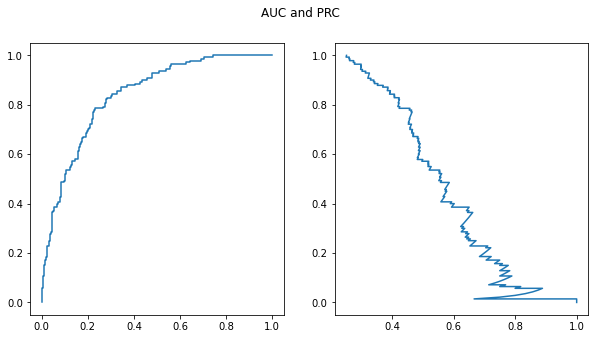

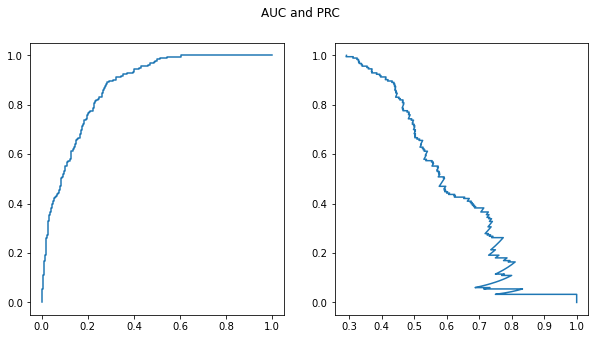

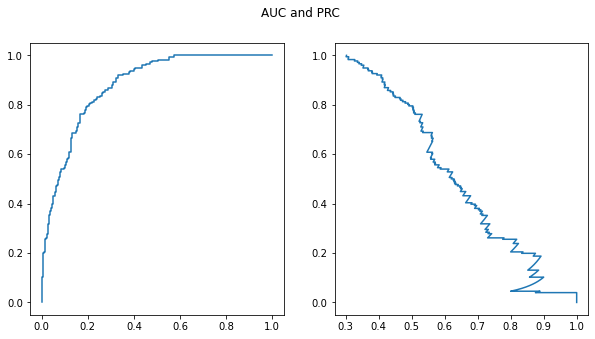

In [3]:
#30nt version

inputf = 'cas13d_nbt-data_filtered_iscds_linf_contra_iso_percent.csv'
# no iso classification, fold8
#predf1 = 'results/all_guide_f24_mis3_nbt_noiso/guide_nolin_fourf_classification/test_prediction_8of11.csv'
# cd val, isorefseq, fold6
predf1 = 'results/all_guide_f24_mis3_nbt_pred_cd_train_isoref/guide_nolin_fivef_classification/test_prediction_6of11.csv'
df_in = pd.read_csv(inputf)
df_pred1 = pd.read_csv(predf1)
df_all1= df_in.merge(df_pred1, left_on='guide', right_on='spacer sequence')
df_all1["pred_rank_by_gene_pct"] = df_all1.groupby("Screen")["predicted_value_sigmoid"].rank(pct=True)

gene_list =['CD46','CD55','CD71']
for gene in gene_list:
    gene_df = df_all1[df_all1["Screen"]==gene]
    rank_t =  1- gene_df['relative_ratio'].values
    pred_rank = gene_df['pred_rank_by_gene_pct'].values
    goodg_true = 1 - gene_df['binary_relative_ratio'].values
    sr, srp = stats.spearmanr(pred_rank,rank_t)
    print(gene)
    print('spearmanr '+str(sr))
    get_classification_metrics('cnnhp1_isoref', 6, pred_rank,goodg_true,save = False)

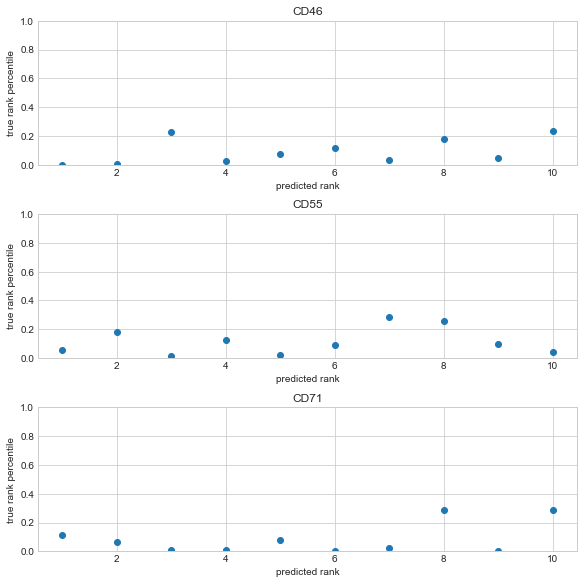

In [4]:
#top10 guides for each gene
df_all1["pred_rank_by_gene"] = df_all1.groupby("Screen")["predicted_value_sigmoid"].rank(ascending=False)
cd46 = df_all1[df_all1["Screen"]=='CD46']
cd46_top10 = cd46[cd46["pred_rank_by_gene"]<=10]

cd55 = df_all1[df_all1["Screen"]=='CD55']
cd55_top10 = cd55[cd55["pred_rank_by_gene"]<=10]

cd71 = df_all1[df_all1["Screen"]=='CD71']
cd71_top10 = cd71[cd71["pred_rank_by_gene"]<=10]


plt.style.use('seaborn-whitegrid')
fig, axs =  plt.subplots(3,figsize=(8,8),constrained_layout=True)

axs[0].scatter(cd46_top10['pred_rank_by_gene'].values,cd46_top10['relative_ratio'].values,label='CD46')
axs[0].set_title('CD46')
axs[0].set_xlabel('predicted rank')
axs[0].set_ylabel('true rank percentile')
axs[0].set_ylim((0, 1))

axs[1].scatter(cd55_top10['pred_rank_by_gene'].values,cd55_top10['relative_ratio'].values,label='CD55')
axs[1].set_title('CD55')
axs[1].set_xlabel('predicted rank')
axs[1].set_ylabel('true rank percentile')
axs[1].set_ylim((0, 1))

axs[2].scatter(cd71_top10['pred_rank_by_gene'].values,cd71_top10['relative_ratio'].values,label='CD71')
axs[2].set_title('CD71')
axs[2].set_xlabel('predicted rank')
axs[2].set_ylabel('true rank percentile')
axs[2].set_ylim((0, 1))

plt.savefig(fname=predf1[:-4]+'_individual_gene_rank.png',dpi=600,bbox_inches='tight')

In [8]:
#fold2
predf1 = 'results/all_guide_f24_mis3_nbt_noiso/guide_nolin_fourf_classification/test_prediction_2of11.csv'
df_in = pd.read_csv(inputf)
df_pred1 = pd.read_csv(predf1)
df_all1= df_in.merge(df_pred1, left_on='guide', right_on='spacer sequence')
df_all1["pred_rank_by_gene_pct"] = df_all1.groupby("Screen")["predicted_value_sigmoid"].rank(pct=True)

gene_list =['CD46','CD55','CD71']
for gene in gene_list:
    gene_df = df_all1[df_all1["Screen"]==gene]
    rank_t =  1- gene_df['relative_ratio'].values
    pred_rank = gene_df['pred_rank_by_gene_pct'].values
    goodg_true = 1 - gene_df['binary_relative_ratio'].values
    sr, srp = stats.spearmanr(pred_rank,rank_t)
    print(gene)
    print('spearmanr '+str(sr))
    get_classification_metrics('cnnhp1_noiso',2, pred_rank,goodg_true,save = False)

CD46
spearmanr 0.5752377920304793
AUROC 0.8109693877551021
AUPRC 0.5349260005141364
CD55
spearmanr 0.6550932432394826
AUROC 0.8692533856022808
AUPRC 0.6050834027838363
CD71
spearmanr 0.6097413799790146
AUROC 0.8676039788823074
AUPRC 0.6367819203430019
